## Kaggle HateSpeech Classification

Initially, we set up a wide array of hyperparameter configurations for all possible classification models
- KNeighbors
- Support Vector Machines
- Linear models such as Logistic Regression and Stochastic Gradient Descent
- Naive Bayes models such as the Gaussian, Complement and Multinomial Naive Bayes
- Boosting models such as AdaBoost, XGBoost, Catboost, LightGBM, GradientBoosting
- Ensemble models such as RandomForest, Bagging, Voting

 to establish our baseline. However, this approach proved to be extremely computationally intensive. Some models took up to 14 hours to run, while one particular model ran continuously for three days. While our CPUs were overwhelmed, our GPUs remained largely idle, prompting us to seek ways to leverage our expensive GPUs more effectively.

We discovered that scikit-learn, being a machine learning library and not a deep learning library, was not designed for GPU usage and required a CUDA setup on a Linux OS to function on GPUs. Since most of us were running Windows with Nvidia hardware, this solution was not feasible. We also explored other options to run scikit-learn models on GPUs, but found they only supported GPU acceleration for predictions, not training, via libraries like [Hummingbird](https://www.youtube.com/watch?v=GbC1BujV-J4).

Our last option was to use Nvidia's RAPIDs cuDF and [cuML](https://docs.rapids.ai/api/cuml/stable/api/) libraries, which offer scikit-learn-compatible counterparts with GPU acceleration. Discovering this solution was a significant relief, as it allowed us to utilize GPUs to their full potential and significantly speed up our computations. Thus, wherever possible, we used the cuML versions of the models on Kaggle

We split our training set into the standard 80% train and 20% validation ratio with stratify=y to make splitted sets imbalance ratio ∝ original training set, and did not apply any feature engineering or scaling techniques. Hyperparameter-tuning was achieved via Randomized Search Cross Validation, as opposed to the exhaustive Grid Search which would take significantly longer for similar results.

In [ ]:
# Done on Kaggle for their GPUs
# Special cuML Dataframes to work with cuML
import cudf
from cuml import train_test_split

df_train = cudf.read_csv("/kaggle/input/ml-t5-tea/train_tfidf_features.csv")
X = df_train.drop(['label', 'id'], axis=1)
y = df_train['label']

df_test = cudf.read_csv("/kaggle/input/ml-t5-tea/test_tfidf_features.csv")
X_test = df_test.drop(['id'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1059, stratify=y)

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

In [49]:
# Normal CPU scikit-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


df_train = pd.read_csv(f"{FOLDER}/data/train_tfidf_features.csv")
X = df_train.drop(['label', 'id'], axis=1)
y = df_train['label']

df_test = pd.read_csv(f"{FOLDER}/data/test_tfidf_features.csv")
X_test = df_test.drop(['id'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1059, stratify=y)

In [ ]:
import itertools
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier as skKNeighborsClassifier
from sklearn.naive_bayes import GaussianNB as skGaussianNB, MultinomialNB as skMultinomialNB, ComplementNB as skComplementNB
from sklearn.svm import SVC as skSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression as skLogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, RandomForestClassifier as skRandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from cuml.neighbors import KNeighborsClassifier
from cuml.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from cuml.svm import SVC
from cuml.linear_model import LogisticRegression 
from cuml.ensemble import RandomForestClassifier

config_1 = {
    "sk_knn": {
        "param_distributions": {
            "n_neighbors": range(1, 13001, 1000),  
            "p": [1, 2],  # Manhattan or Euclidean distance
            "weights": ["uniform", "distance"],  # Weight function used in prediction
            "algorithm": ["ball_tree", "kd_tree", "brute"]  # Algorithm used to compute the nearest neighbors
        },
        "n_iter": 10,
        "cv": 10
    },
    "sk_knn": {
        "param_distributions": {
            "n_neighbors": range(1, 13001, 1000),  
        },
        "n_iter": 10,
        "cv": 10
    },
    "gnb": {
        "param_distributions": {
            "var_smoothing": np.logspace(0, -9, num=100)  # Portion of the largest variance of all features added to variances for stability
        },
        "n_iter": 10,
        "cv": 10
    },
    "sk_mnb": {
        "param_distributions": {
            'alpha': np.logspace(-3, 1, 100),  
            "force_alpha": [True, False], 
            "fit_prior": [True, False]
        },
        "n_iter": 10,
        "cv": 10
    },
    "mnb": {
        "param_distributions": {
            'alpha': np.logspace(-3, 1, 100),  
            "fit_prior": [True, False]
        },
        "n_iter": 10,
        "cv": 10
    },
    "sk_cnb": {
        "param_distributions": {
            'alpha': np.logspace(-3, 1, 100),  
            "force_alpha": [True, False], # Parameter Doesn't exist for cuML version
            "fit_prior": [True, False],
            "norm": [True, False]
        },
        "n_iter": 10,
        "cv": 10
    },
    "cnb": {
        "param_distributions": {
            'alpha': np.logspace(-3, 1, 100),  
            "fit_prior": [True, False],
            "norm": [True, False]
        },
        "n_iter": 10,
        "cv": 10
    },
    "svc": {
        "param_distributions": {
            "C": [0.1, 1, 10, 100, 1000],  # Regularization parameter
            "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Kernel type
            "degree": range(1, 6),  # Degree for poly/rbf kernels
            "gamma": ["scale", "auto"] + [1e-3, 1e-4, 1e-5]  # Kernel coefficient
        },
        "n_iter": 10,
        "cv": 10
    },
    "random_forest": {
        "param_distributions": {
            "n_estimators": range(10, 4001, 5),  # Number of trees in the forest
            "max_features": ["sqrt", "log2"],  # Number of features to consider for best split
            "max_depth": range(1, 101, 5),  # Max depth of the tree
            "min_samples_split": range(2, 11),  # Min number of samples required to split an internal node
            "min_samples_leaf": range(1, 11),  # Min number of samples required to be at a leaf node
            "criterion": ['entropy', 'gini', 'log_loss'],
            "bootstrap": [True, False]
        },
        "n_iter": 10,
        "cv": 50
    },
    "xgboost": {
        "param_distributions": {
            "n_estimators": range(100, 10001, 100),  # Number of boosting rounds
            "max_depth": range(1, 11),  # Maximum tree depth
            "learning_rate": np.logspace(-3, 0, num=100),  # Learning rate
            "subsample": np.linspace(0.5, 1.0, 10),  # Subsample ratio of the training instances
            "colsample_bytree": np.linspace(0.5, 1.0, 10)  # Subsample ratio of columns when constructing each tree
        },
        "n_iter": 10,
        "cv": 10
    },
    "catboost": {
        "param_distributions": {
            "iterations": range(100, 10001, 3000),  # Number of trees
            "depth": range(1, 11, 2),  # Depth of the tree
            "learning_rate": np.logspace(-3, 0, num=5),  # Learning rate
            "l2_leaf_reg": np.logspace(-3, 3, num=5),  # L2 regularization term on weights
            "border_count": range(1, 255, 100)  # Number of splits for numerical features
        },
        "n_iter": 1,
        "cv": 2
    },
    "voting_ensemble": {
        "param_distributions": {
            "voting": ["soft", "hard"],  # Voting method
            "weights": [None, [1, 2], [2, 1], [1, 1]],  # Weights for each classifier
            "flatten_transform": [True, False],  # Whether to flatten the output of transform to 1d array
        },
        "n_iter": 10,
        "cv": 100
    },
    "bagging": {
        "param_distributions": {
            "n_estimators": range(10, 1001, 50),  # Number of base estimators in the ensemble
            "max_samples": np.linspace(0.1, 1.0, 10),  # Max samples drawn from X to train each base estimator
            "max_features": np.linspace(0.1, 1.0, 10),  # Max features drawn from X to train each base estimator
            "bootstrap": [True, False],  # Whether samples are drawn with replacement
            "bootstrap_features": [True, False]  # Whether features are drawn with replacement
        },
        "n_iter": 10,
        "cv": 10
    },
    "sgd": {
      "param_distributions": {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
        'l1_ratio': [0.0, 0.15, 0.5, 0.85, 1.0],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1],
        'max_iter': range(1000, 11000, 1000),
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
        'eta0': [0.001, 0.01, 0.1] 
        },
        "n_iter": 10,
        "cv": 10
    },
}

config_2 = {
    "knn": {
        "param_distributions": {
            "n_neighbors": range(800, 1300, 5), 
        },
        "n_iter": 10,
        "cv": 10
    },
    "mnb": {
        "param_distributions": {
            'alpha': np.logspace(np.log10(2.7), np.log10(5.7), 10000),  
            'alpha': np.logspace(-5, 5, 10000), 
            "fit_prior": [True, False]
        },
        "n_iter": 30,
        "cv": 100
    },
    "cnb": {
        "param_distributions": {
            'alpha': np.logspace(-7, np.log10(7), 100000), 
            "fit_prior": [True, False],
            "norm": [True, False]
        },
        "n_iter": 30,
        "cv": 100
    },
    "svc": {
        "param_distributions": {
            "C": range(800,1200, 5),
            "kernel": ["poly"],  
            "degree": [4]  ,
            "gamma": ["scale"] + [1e-3, 1e-4, 1e-5]  
        },
        "n_iter": 10,
        "cv": 10
    },
    "random_forest": {
        "param_distributions": {
            "n_estimators": range(850, 930),  
            "max_features": ["log2"],  
            "max_depth": range(4, 18),  
            "min_samples_split": range(2,8),  
            "min_samples_leaf": [2],
            'min_impurity_decrease': [0.0], 
            'max_leaf_nodes': range(8,16),
            'criterion': ['log_loss'], 
            'class_weight': ['balanced']
        },
        "n_iter": 10,
        "cv": 100
    },
    "voting_ensemble": {
        "param_distributions": {
            "voting": ["soft", "hard"], 
            "weights": [None, [1, 2], [2, 1], [1, 1], [3, 2], [2, 3]],  
            "flatten_transform": [True], 
        },
        "n_iter": 10,
        "cv": 100
    },
}

config_3 = {
    "voting_ensemble": {
        "param_distributions": {
            "voting": ["soft"], 
            # Get auto-generated list of 5 numbers, where each number can be 1 / 2 / 3
            "weights": [None] + list(itertools.product([1,2,3], repeat=5)), 
            "flatten_transform": [True],  
        },
        "n_iter": 3,
        "cv": 3
    },
    "mnb": {
        "param_distributions": {
            'alpha': np.logspace(np.log10(2.7), np.log10(6), 10000),  
            'alpha': np.logspace(-5, 5, 10000), 
            "force_alpha": [True, False],
            "fit_prior": [True, False]
        },
        "n_iter": 30,
        "cv": 100
    },
    "cnb": {
        "param_distributions": {
            'alpha': np.logspace(np.log10(4), np.log10(6.5), 10000), 
            "force_alpha": [True,False],
            "fit_prior": [True, False],
            "norm": [True, False]
        },
        "n_iter": 30,
        "cv": 100
    },
}

models = {
        "random_forest": RandomForestClassifier,
        "sk_random_forest": skRandomForestClassifier,
        "xgboost": XGBClassifier,
        "catboost": CatBoostClassifier,
        "voting_ensemble": VotingClassifier,
        "sk_knn": skKNeighborsClassifier,
        "knn": KNeighborsClassifier,
        "bagging": BaggingClassifier,
        "svc": SVC,
        "sgd": SGDClassifier,
        "gnb": GaussianNB,
        "mnb": MultinomialNB,
        "sk_mnb": skMultinomialNB,
        "cnb": ComplementNB,
        "sk_cnb": skComplementNB,
    }

def run_model_with_config(model_str, config, X_train, y_train, X_val, y_val):
    global models, X_test

    model = models[model_str]
    print(f"Running {model_str.upper()} with config:", config[model_str])
    
    if model_str == "voting_ensemble":
        estimators = [
            # Optimal hyperparameters obtained after running the individual RandomSearchCV models below
            # SVC NEEDS probability=True if voting=soft
            ('svc', SVC(**{'kernel': 'poly', 'gamma': 0.001, 'degree': 2, 'C': 1000}, probability=True)),
            ('knn', KNeighborsClassifier(**{'n_neighbors': 6000})),
            ('catboost', CatBoostClassifier(**{'iterations': 9100, 'depth': 1})),
            ('mnb', MultinomialNB(alpha=2.0442360985995727, fit_prior=False)),
            ('cnb', ComplementNB(norm=False, fit_prior=True, alpha=2.825008855457207)),
   ]
        classifier = VotingClassifier(estimators=estimators)
    elif model_str == "catboost":
        # Using Kaggle's free GPUs
        classifier = CatBoostClassifier(task_type='GPU')
    elif model_str == "xgboost":
        # Using Kaggle's free GPUs
        classifier = XGBClassifier(tree_method = "hist", device = "cuda")
    else:
        classifier = model()
        
    random_search = RandomizedSearchCV(
        classifier,
        param_distributions=config[model_str]["param_distributions"],
        n_iter=config[model_str]["n_iter"],
        cv=config[model_str]["cv"],
        random_state=1059,
        n_jobs=-1,
        scoring="f1_macro",
        verbose=2,
        error_score='raise'
    )
    random_search.fit(X_train.to_pandas().values, y_train.to_cupy().get())
    print(f"Best params: {random_search.best_params_}")
    best_params_model = random_search.best_estimator_

    y_pred_val = best_params_model.predict(X_val.to_pandas().values)
    validation_scores = {
        "Accuracy": accuracy_score(y_val.to_pandas().values, y_pred_val),
        "Precision": precision_score(y_val.to_pandas().values, y_pred_val),
        "Recall": recall_score(y_val.to_pandas().values, y_pred_val),
        "F1": f1_score(y_val.to_pandas().values, y_pred_val, average="macro")
    }

    print(f"{model_str.upper()} Validation Scores: {validation_scores}")

    y_pred_test = best_params_model.predict(X_test.to_cupy().get())
    pred_df = pd.DataFrame({ "id": np.arange(17185, 21481), "label": y_pred_test })
    pred_df["label"] = pred_df['label'].astype(int)
    if model_str == "voting_ensemble":
        estimator_names = '-'.join([name for name, _ in estimators])
        pred_df.to_csv(f"predictions_{model_str}_{estimator_names}_{'-'.join([f'{k}_{v}' for k, v in random_search.best_params_.items()])}.csv", index=False)
    else:
        pred_df.to_csv(f"predictions_{model_str}_{'-'.join([f'{k}_{v}' for k, v in random_search.best_params_.items()])}.csv", index=False)

As our objective was to try as many models as possible in the shortest time, we first utilized majority of the classification counterparts cuML supports. This allowed us to iterate rapidly. However, we soon came to realize cuML was not as developed as scikit-learn yet, and did not support some crucial hyperparameters that would be the difference between a good and a bad model, such as the 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga' solvers for Logistic Regression

![lr_solvers.jpg](./imgs/lr_solvers.jpg)

and the 'criterion' implementations for Random Forest were different

![random_forest_criterion.jpg](./imgs/random_forest_criterion.jpg)

and KNeighborsClassifier for scikit-learn and cuML gave *very* different results due to the limited variety of hyperparameters cuML's supports, as seen below

Therefore, customization was the trade-off for speed. Granted, at this time we did not know if these options would matter anyway and we were blindly testing all models, but less customization naturally means less ability to tune and less potential for a good model. Thus, we fell back on the scikit-learn variations of them to better explore their potentials.

In [15]:
# Example of how the configurations were used
# Horrible cuML KNeighborsClassifier 
run_model_with_config("knn", config_1, X_train, y_train, X_val, y_val)

# Key hyperparameters = Validation Macro-F1
# {'n_neighbors': 6000} = 0.44923808910337054


Running KNN with config: {'param_distributions': {'n_neighbors': range(1, 13001, 1000)}, 'n_iter': 10, 'cv': 10}
[I] [04:17:17.088300] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[I] [04:17:17.094546] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [04:17:17.095000] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [04:17:17.095435] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [04:17:17.095834] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [04:17:17.215932] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [04:17:17.217523] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [04:17:17.218351] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [04:17:17.219144] Unused keyword parameter: n_jobs during cuML estimator initializa

There are also multiple configs (config_1, config_2, config_3) for specific models as we wanted to converge into the most optimal version, with 

narrower ranges and smaller intervals Eg. 

config_1_svc

![config_1_svc.jpg](./imgs/config_1_svc.jpg)

vs

config_2_svc once config_1_svc ended choosing C=1000

![config_2_svc.jpg](./imgs/config_2_svc.jpg)

or 

to explore more in-depth of an optimal hyperparameter value after a successful iteration Eg.

config_3_cnb

![config_3_cnb.jpg](./imgs/config_3_cnb.jpg)


In [12]:
# Another really horrible attempt of cuML SVC
run_model_with_config("svc", config_1, X_train, y_train, X_val, y_val)

# Key hyperparameters = Validation Macro-F1
# {'kernel': 'poly', 'gamma': 0.001, 'degree': 2, 'C': 1000} = 0.3822366055375764


Running SVC with config: {'param_distributions': {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': range(1, 6), 'gamma': ['scale', 'auto', 0.001, 0.0001, 1e-05]}, 'n_iter': 10, 'cv': 10}
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END alpha=0.015950127015422227, fit_prior=True, norm=True; total time=   2.1s
[CV] END alpha=0.015950127015422227, fit_prior=True, norm=True; total time=   1.9s
[CV] END alpha=0.015950127015422227, fit_prior=True, norm=True; total time=   1.9s
[CV] END alpha=0.015950127015422227, fit_prior=True, norm=True; total time=   2.0s
[CV] END alpha=0.015950127015422227, fit_prior=True, norm=True; total time=   2.4s
[CV] END alpha=0.015950127015422227, fit_prior=True, norm=True; total time=   2.0s
[CV] END alpha=0.015950127015422227, fit_prior=True, norm=True; total time=   1.9s
[CV] END alpha=0.015950127015422227, fit_prior=True, norm=True; total time=   2.1s
[CV] END alpha=0.015950127015422227, fit_prior

In [8]:
run_model_with_config("catboost", config_1, X_train, y_train, X_val, y_val)

# Key hyperparameters = Validation Macro-F1
# {'iterations': 9100, 'depth': 1} = 0.6103588221499888


Running CATBOOST with config: {'param_distributions': {'iterations': range(100, 10001, 3000), 'depth': range(1, 11, 2)}, 'n_iter': 1, 'cv': 2}
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Learning rate set to 0.004035
0:	learn: 0.6928265	total: 63.6ms	remaining: 9m 39s
1:	learn: 0.6925084	total: 88.4ms	remaining: 6m 42s
2:	learn: 0.6921930	total: 113ms	remaining: 5m 44s
3:	learn: 0.6918800	total: 138ms	remaining: 5m 12s
4:	learn: 0.6916557	total: 162ms	remaining: 4m 55s
5:	learn: 0.6913472	total: 187ms	remaining: 4m 43s
6:	learn: 0.6910853	total: 211ms	remaining: 4m 34s
7:	learn: 0.6908304	total: 235ms	remaining: 4m 27s
8:	learn: 0.6906122	total: 259ms	remaining: 4m 22s
9:	learn: 0.6903117	total: 283ms	remaining: 4m 17s
10:	learn: 0.6900134	total: 307ms	remaining: 4m 13s
11:	learn: 0.6897204	total: 330ms	remaining: 4m 10s
12:	learn: 0.6894273	total: 352ms	remaining: 4m 6s
13:	learn: 0.6891363	total: 374ms	remaining: 4m 2s
14:	learn: 0.6888479	total: 398ms	remaining: 4m
1

In [6]:
run_model_with_config("mnb", config_1, X_train, y_train, X_val, y_val)

# Key hyperparameters = Validation Macro-F1
# {'fit_prior': False, 'alpha': 0.9770099572992257} = 0.6941555358140986


Running MNB with config: {'param_distributions': {'alpha': array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03, 1.32194115e-03,
       1.45082878e-03, 1.59228279e-03, 1.74752840e-03, 1.91791026e-03,
       2.10490414e-03, 2.31012970e-03, 2.53536449e-03, 2.78255940e-03,
       3.05385551e-03, 3.35160265e-03, 3.67837977e-03, 4.03701726e-03,
       4.43062146e-03, 4.86260158e-03, 5.33669923e-03, 5.85702082e-03,
       6.42807312e-03, 7.05480231e-03, 7.74263683e-03, 8.49753436e-03,
       9.32603347e-03, 1.02353102e-02, 1.12332403e-02, 1.23284674e-02,
       1.35304777e-02, 1.48496826e-02, 1.62975083e-02, 1.78864953e-02,
       1.96304065e-02, 2.15443469e-02, 2.36448941e-02, 2.59502421e-02,
       2.84803587e-02, 3.12571585e-02, 3.43046929e-02, 3.76493581e-02,
       4.13201240e-02, 4.53487851e-02, 4.97702356e-02, 5.46227722e-02,
       5.99484250e-02, 6.57933225e-02, 7.22080902e-02, 7.92482898e-02,
       8.69749003e-02, 9.54548457e-02, 1.04761575e-01, 1.14975700e-01,
       1.26185688

In [9]:
# Refined Iteration using narrow ranges, smaller intervals
run_model_with_config("mnb", config_2, X_train, y_train, X_val, y_val)

# Key hyperparameters = Validation Macro-F1
# {'fit_prior': False, 'alpha': 2.0442360985995727} = 0.7013432052728406


Running MNB with config: {'param_distributions': {'alpha': array([1.00000000e-05, 1.00230547e-05, 1.00461625e-05, ...,
       9.95404959e+04, 9.97699834e+04, 1.00000000e+05]), 'fit_prior': [True, False]}, 'n_iter': 30, 'cv': 100}
Fitting 100 folds for each of 30 candidates, totalling 3000 fits
[CV] END .......alpha=0.0004113025633330323, fit_prior=False; total time=   3.4s
[CV] END .......alpha=0.0004113025633330323, fit_prior=False; total time=   2.2s
[CV] END .......alpha=0.0004113025633330323, fit_prior=False; total time=   2.0s
[CV] END .......alpha=0.0004113025633330323, fit_prior=False; total time=   2.1s
[CV] END .......alpha=0.0004113025633330323, fit_prior=False; total time=   2.1s
[CV] END .......alpha=0.0004113025633330323, fit_prior=False; total time=   2.9s
[CV] END .......alpha=0.0004113025633330323, fit_prior=False; total time=   2.0s
[CV] END .......alpha=0.0004113025633330323, fit_prior=False; total time=   2.2s
[CV] END .......alpha=0.0004113025633330323, fit_prior=F

In [10]:
run_model_with_config("cnb", config_1, X_train, y_train, X_val, y_val)

# Key hyperparameters = Validation Macro-F1
# {'norm': False, 'fit_prior': True, 'alpha': 5.722367659350221} = 0.7024989684456076


Running CNB with config: {'param_distributions': {'alpha': array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03, 1.32194115e-03,
       1.45082878e-03, 1.59228279e-03, 1.74752840e-03, 1.91791026e-03,
       2.10490414e-03, 2.31012970e-03, 2.53536449e-03, 2.78255940e-03,
       3.05385551e-03, 3.35160265e-03, 3.67837977e-03, 4.03701726e-03,
       4.43062146e-03, 4.86260158e-03, 5.33669923e-03, 5.85702082e-03,
       6.42807312e-03, 7.05480231e-03, 7.74263683e-03, 8.49753436e-03,
       9.32603347e-03, 1.02353102e-02, 1.12332403e-02, 1.23284674e-02,
       1.35304777e-02, 1.48496826e-02, 1.62975083e-02, 1.78864953e-02,
       1.96304065e-02, 2.15443469e-02, 2.36448941e-02, 2.59502421e-02,
       2.84803587e-02, 3.12571585e-02, 3.43046929e-02, 3.76493581e-02,
       4.13201240e-02, 4.53487851e-02, 4.97702356e-02, 5.46227722e-02,
       5.99484250e-02, 6.57933225e-02, 7.22080902e-02, 7.92482898e-02,
       8.69749003e-02, 9.54548457e-02, 1.04761575e-01, 1.14975700e-01,
       1.26185688

In [11]:
# Refined Iteration using narrow ranges, smaller intervals
run_model_with_config("cnb", config_2, X_train, y_train, X_val, y_val)

# Key hyperparameters = Validation Macro-F1
# {'norm': False, 'fit_prior': True, 'alpha': 2.825008855457207} = 0.704362044712922


Running CNB with config: {'param_distributions': {'alpha': array([1.00000000e-07, 1.00018066e-07, 1.00036135e-07, ...,
       6.99747147e+00, 6.99873562e+00, 7.00000000e+00]), 'fit_prior': [True, False], 'norm': [True, False]}, 'n_iter': 30, 'cv': 100}
Fitting 100 folds for each of 30 candidates, totalling 3000 fits
[CV] END alpha=5.722367659350221, fit_prior=True, norm=False; total time=   2.3s
[CV] END alpha=0.06579332246575682, fit_prior=False, norm=True; total time=   2.3s
[CV] END alpha=0.06579332246575682, fit_prior=False, norm=True; total time=   2.1s
[CV] END alpha=0.9770099572992257, fit_prior=True, norm=True; total time=   2.2s
[CV] END alpha=0.9770099572992257, fit_prior=True, norm=True; total time=   1.7s
[CV] END alpha=0.9770099572992257, fit_prior=True, norm=True; total time=   1.9s
[CV] END alpha=0.0036783797718286343, fit_prior=False, norm=False; total time=   2.1s
[CV] END alpha=0.0036783797718286343, fit_prior=False, norm=False; total time=   1.5s
[CV] END alpha=0.01

In [31]:
run_model_with_config("random_forest", config_1, X_train, y_train, X_val, y_val)

# Key hyperparameters = Validation Macro-F1
# {'n_estimators': 1390, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 76, 'criterion': 'entropy', 'bootstrap': True} = 0.27602191319005476



Running RANDOM_FOREST with config: {'param_distributions': {'n_estimators': range(10, 4001, 5), 'max_features': ['sqrt', 'log2'], 'max_depth': range(1, 101, 5), 'min_samples_split': range(2, 11), 'min_samples_leaf': range(1, 11), 'criterion': ['entropy', 'gini', 'log_loss'], 'bootstrap': [True, False]}, 'n_iter': 10, 'cv': 20}
Fitting 20 folds for each of 10 candidates, totalling 200 fits
[CV] END bootstrap=True, criterion=log_loss, max_depth=86, max_features=log2, min_samples_leaf=8, min_samples_split=9, n_estimators=1130; total time= 4.2min
[CV] END bootstrap=True, criterion=log_loss, max_depth=86, max_features=log2, min_samples_leaf=8, min_samples_split=9, n_estimators=1130; total time= 4.2min
[CV] END bootstrap=True, criterion=log_loss, max_depth=86, max_features=log2, min_samples_leaf=8, min_samples_split=9, n_estimators=1130; total time= 4.2min
[CV] END bootstrap=True, criterion=log_loss, max_depth=86, max_features=log2, min_samples_leaf=8, min_samples_split=9, n_estimators=113

In [33]:
run_model_with_config("random_forest", config_2, X_train, y_train, X_val, y_val)

# Key hyperparameters = Validation Macro-F1
# {'n_estimators': 901, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 15, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'log_loss', 'class_weight': 'balanced'} = 0.6949428274297715


Running RANDOM_FOREST with config: {'param_distributions': {'n_estimators': range(850, 930), 'max_features': ['log2'], 'max_depth': range(4, 18), 'min_samples_split': range(2, 8), 'min_samples_leaf': [2], 'min_impurity_decrease': [0.0], 'max_leaf_nodes': range(8, 16), 'criterion': ['log_loss'], 'class_weight': ['balanced']}, 'n_iter': 10, 'cv': 100}
Fitting 100 folds for each of 10 candidates, totalling 1000 fits
[CV] END class_weight=balanced, criterion=log_loss, max_depth=4, max_features=log2, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=6, n_estimators=862; total time=  15.2s
[CV] END class_weight=balanced, criterion=log_loss, max_depth=4, max_features=log2, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=6, n_estimators=862; total time=  17.0s
[CV] END class_weight=balanced, criterion=log_loss, max_depth=4, max_features=log2, max_leaf_nodes=13, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_spli

In [32]:
run_model_with_config("voting_ensemble", config_3, X_train, y_train, X_val, y_val)

# Key hyperparameters = Validation Macro-F1
# {'weights': (2, 1, 2, 2, 2), 'voting': 'soft', 'flatten_transform': True} = 0.6423788915552399


Running VOTING_ENSEMBLE with config: {'param_distributions': {'voting': ['soft'], 'weights': [None, (1, 1, 1, 1, 1), (1, 1, 1, 1, 2), (1, 1, 1, 2, 1), (1, 1, 1, 2, 2), (1, 1, 2, 1, 1), (1, 1, 2, 1, 2), (1, 1, 2, 2, 1), (1, 1, 2, 2, 2), (1, 2, 1, 1, 1), (1, 2, 1, 1, 2), (1, 2, 1, 2, 1), (1, 2, 1, 2, 2), (1, 2, 2, 1, 1), (1, 2, 2, 1, 2), (1, 2, 2, 2, 1), (1, 2, 2, 2, 2), (2, 1, 1, 1, 1), (2, 1, 1, 1, 2), (2, 1, 1, 2, 1), (2, 1, 1, 2, 2), (2, 1, 2, 1, 1), (2, 1, 2, 1, 2), (2, 1, 2, 2, 1), (2, 1, 2, 2, 2), (2, 2, 1, 1, 1), (2, 2, 1, 1, 2), (2, 2, 1, 2, 1), (2, 2, 1, 2, 2), (2, 2, 2, 1, 1), (2, 2, 2, 1, 2), (2, 2, 2, 2, 1), (2, 2, 2, 2, 2)], 'flatten_transform': [True]}, 'n_iter': 3, 'cv': 3}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END flatten_transform=True, voting=soft, weights=(2, 1, 1, 2, 2); total time= 8.7min
[CV] END flatten_transform=True, voting=soft, weights=(2, 1, 2, 2, 2); total time= 8.2min
[CV] END flatten_transform=True, voting=soft, weights=(1, 2, 1,

We also sourced around and tried [MNB Optuna from 2022 50.007 'Code Discussion'](https://www.kaggle.com/code/visshalnatarajan/multinomial-nb-with-optuna-920b9f62)

In [5]:
# %pip install optuna
import optuna
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

def objective(trial):
    cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=3)
    # define params grid to optimize macro f1
    alpha = trial.suggest_float('alpha', 2.0, 5.0)
    fit_prior =  trial.suggest_categorical('fit_prior', [True, False])
    model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=cv, scoring="f1_macro")
    return score.mean()
    
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=None, timeout=42000, n_jobs = 2)

print(f"Optuna MNB best hyperparameters for MNB: {study.best_trial.params}")

model = MultinomialNB(**study.best_trial.params)
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
print(f"Optuna MNB Validation Scores: {f1_score(y_val, y_pred_val, average='macro')}")

# Key hyperparameters = Validation Macro-F1
# {'alpha': 3.0808156150982167, 'fit_prior': False} = 0.7082761801196539



[I 2024-08-01 03:37:56,554] A new study created in memory with name: no-name-cae37af9-4f99-4db5-8b6f-f22453d3d593
[I 2024-08-01 03:38:11,229] Trial 0 finished with value: 0.691875112996813 and parameters: {'alpha': 2.3509677043036095, 'fit_prior': False}. Best is trial 0 with value: 0.691875112996813.
[I 2024-08-01 03:38:12,391] Trial 1 finished with value: 0.691650928431478 and parameters: {'alpha': 4.152110387250227, 'fit_prior': False}. Best is trial 0 with value: 0.691875112996813.
[I 2024-08-01 03:38:17,011] Trial 2 finished with value: 0.5340677500067629 and parameters: {'alpha': 4.795996961222247, 'fit_prior': True}. Best is trial 0 with value: 0.691875112996813.
[I 2024-08-01 03:38:19,973] Trial 3 finished with value: 0.6124777701225878 and parameters: {'alpha': 2.1788927034065337, 'fit_prior': True}. Best is trial 0 with value: 0.691875112996813.
[I 2024-08-01 03:38:23,158] Trial 4 finished with value: 0.6011994647361997 and parameters: {'alpha': 2.6338993727727456, 'fit_pri

Eventually, it was clear iterating through singular baseline models would not create a winner

Day 12 with a Multinomial Naive Bayes model, achieving 0.71366 on the 20% public test set, far above the blue line with hyperparameters 
- force_alpha=False
- fit_prior=False
- alpha=2.0442360985995728
- train_test_split_size=0.1

![day_12.jpg](./imgs/day_12.jpg)

However, when the private leaderboard was shown for the first time for our class, our "winner" was unbelievably far below the red line, achieving a mere 0.68651...

![mnb_failure.jpg](./imgs/mnb_failure.jpg)

In fact, the first team was even lower than us and this was when Prof Roy warned us against overfitting. Therefore, we came to the conclusion, that no singular baseline models should be used and reviewed our previous submissions for an ensemble-type model that would generalize and perform better, which was the scikit-learn Random Forest model with hyperparameters 
- n_estimators=901
- min_samples_split=5
- min_samples_leaf=2
- min_impurity_decrease=0.0
- max_leaf_nodes=15
- max_features=log2
- max_depth=15,criterion=log_loss
- class_weight=balanced_scaled

Although this only attained 0.70828 on the 20% public test set, we saw it attain 0.69823 on the private leaderboard in our friend's class, jumping so close to the blue line. We knew we were on the right track, and ensemble models were the way to go

![rf_ftw.jpg](./imgs/rf_ftw.jpg)

It was also when we knew we had to gain a deeper understanding of the data we were working with to truly improve on it.

### Understanding the data

In [7]:
print(f"Number of features: {X.shape[1]}\n")

sparsity = (X == 0).sum().sum() / X.size
print(f'Sparsity: {sparsity * 100:.2f}%\n')

overall_min = X.min().min()
overall_max = X.max().max()
print(f'Features range from [{overall_min}, {overall_max}]\n')

class_0s = y[y == 0].shape[0]
class_1s = y[y == 1].shape[0]
assert class_0s + class_1s == y.shape[0]
print(f"Class 0 / Class 1 Ratio: {class_0s / class_1s}\n")

Number of features: 5000

Sparsity: 99.85%

Features range from [0.0, 1.0]

Class 0 / Class 1 Ratio: 1.6231109754235995



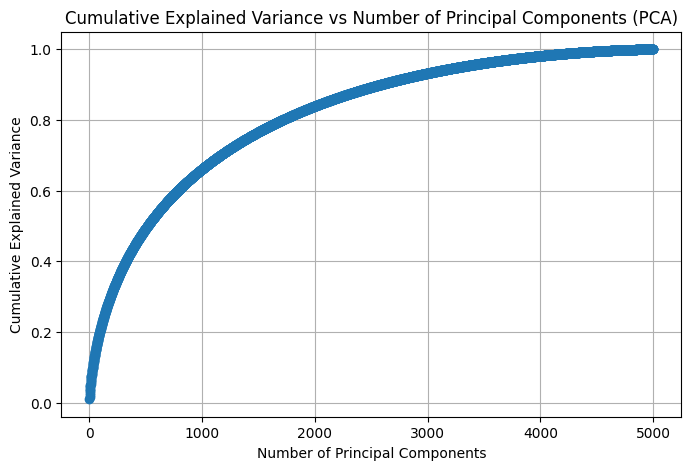

In [20]:
# PCA variance

from sklearn.decomposition import PCA

pca = PCA(n_components=X_train.shape[1])
X_train_pca = pca.fit_transform(X_train)

# Plot the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5)) 
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Principal Components (PCA)')
plt.grid(True)
plt.show()

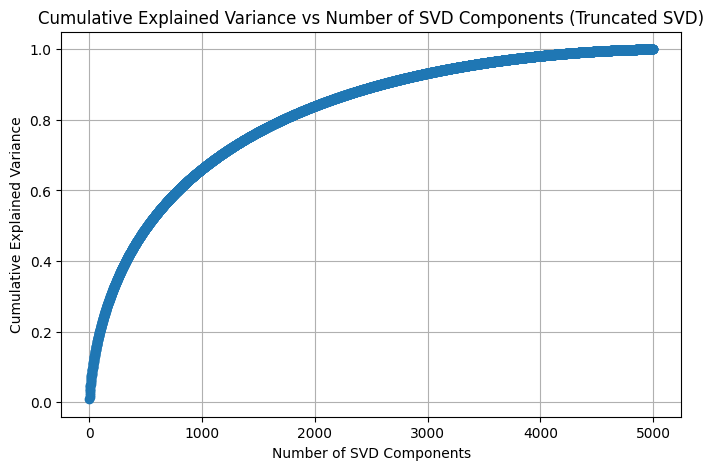

In [18]:
# SVD variance

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=X_train.shape[1])
X_train_svd = svd.fit_transform(X_train)

# Plot the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, X_train.shape[1] + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of SVD Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of SVD Components (Truncated SVD)')
plt.grid(True)
plt.show()

#### Dataset Characteristics
- The dataset comprises 5000 columns of TF-IDF features, which have already been subjected to feature engineering. It also has an extreme sparsity of 99.85%, as most words in a document do not appear in other documents, especially in a large number of posts. This suggests the possibility of dimensionality reduction. 
    - Like in Qn 2, Principal Component Analysis (PCA) could be considered due to its effectiveness in reducing dimensionality by transforming the data into a set of orthogonal components that capture a sufficient amount of variance. [Sources](https://stats.oarc.ucla.edu/spss/seminars/efa-spss/#:~:text=Some%20criteria%20say%20that%20the,about%20four%20to%20five%20components) determine this to be 70-80% of components, which is **~2000 PCA components** in our case
    - Similarly, Singular Value Decomposition (SVD), a generalized form of PCA, is particularly suitable for handling extremely sparse datasets as it decomposes a matrix into three smaller matrices, making it ideal for the dataset. 80% of components is also **~2000 SVD components** in our case
- The features are in the range [0, 1], indicating they had been min-max scaled previously. This scaling implies that the features are not Gaussian (normally distributed). Given the nature of TF-IDF, there are likely numerous and extreme outliers, which are not resolved via min-max scaling and can continue to pose challenges for models that assume or work particularly well with Gaussian-distributed features. Such models comprise of 
    - Gaussian Naive Bayes which computes the probabilities efficiently and particularly effectively when the independence assumption holds, found in Gaussian distributions
    - Logistic Regression which can achieve a faster optimization process and improved decision boundary with Gaussian features
    - SVMs with RBF Kernels which can create a smoother decision boundary with maximized margins with Gaussian features
- The dataset exhibited an imbalanced Class 0 / Class 1 ratio of approximately 1.62, which can bias the model towards the majority class of Class 0. To address this imbalance, techniques can be considered such as 
    - RandomUnderSampler to under-sample the majority class, to match the minority class, which however can result in information loss
    - SMOTE (Synthetic Minority Over-sampling Technique) to over-sample the minority class, to match the majority class and commonly outperform under-sampling but increase likelihood of overfitting since the minority classes are simply replicated
    - a combination of both (SMOTEEN - SMOTE and Edited Nearest Neighbors) to use SMOTE to over-sample the minority class, and ENN to remove noisy instances and misclassified examples from the dataset. This effectively balances the classes

#### Understanding Model Performance
- RandomizedSearchCV: While not a model, RandomizedSearchCV was integral to understand in our search for optimal hyperparameters. Its key parameters were crucial for ensuring the generalizability and robustness of our tuned models
    - cv (cross-validation splitting strategy) ensures the model is evaluated on different subsets of the data, enhancing its generalizability
    - n_iter (number of parameter combinations to try). A higher value increases the chances of finding the optimal hyperparameters but also increases computational cost.
- Multinomial Naive Bayes performed well due to its ability to handle high-dimensional data by assuming conditional independence among features, common among all Naive Bayes variants. While this conditional independence assumption is hardly true in real life, the distribution of dependencies cancels out effects of dependencies. The Multinomial Naive Bayes model is particularly suited for discrete data like word counts, and its Complement variant is designed to address class imbalance, making it a good fit for our dataset. However, it requires non-negative feature values, which could be affected by certain necessary transformations like dimensionality reduction or Gaussian features

A [neat informative table](https://developer.nvidia.com/blog/faster-text-classification-with-naive-bayes-and-gpus/) we found for different use cases of different Naive Bayes models

![nb_table.jpg](./imgs/nb_table.jpg)

#### Feature Transformation Techniques
- Normalization: To achieve normally distributed features, we considered the [Yeo-Johnson PowerTransform and QuantileTransform](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) methods, via scikit-learn's very helpful documentation
    - Yeo-Johnson works with any polarity of data, and reduces the skewness of the data, making it more Gaussian-like. However, it is sensitive to the original distribution and might not handle extreme outliers as effectively as the QuantileTransform.
    - QuantileTransform handles outliers by uniformly spreading the data, and thus is less sensitive to the original distribution.
- Standard Scaling: normalizes the data to a specific range, ensuring that all features contribute equally to the model but do not actually transform the data to achieve a normal distribution

#### Data Augmentation
- Gaussian Mixture Models (GMM) were explored for data augmentation. They require gaussian distributed data to work properly
    - These are generative models and thus can [generate additional data samples](https://medium.com/analytics-vidhya/sampling-from-gaussian-mixture-models-f1ab9cac2721) by modeling the probability distributions of the features, which can be useful for improving model performance. However, this approach increases the dataset size significantly, which we found led to significantly longer training times for models like Gradient Boosting.
    - Additionally, GMMs can also be used for clustering, which [adds an additional feature](https://stackoverflow.com/questions/62342043/improving-classification-by-using-clustering-as-a-feature) (cluster label) to the dataset. This can improve model performance by providing more context to the data.

#### Feature Selection
- [Correlations among features can violate the independence assumption in models like the Naive Bayes](https://stackoverflow.com/a/64125011/16760208), potentially degrading their performance. High correlation among features can lead to multicollinearity, which in turn can cause overfitting and instability in the model's predictions. By identifying and removing highly correlated features, the model can generalize better to unseen data, leading to improved performance in all other models
- The sequence in which data preprocessing steps are applied can significantly impact the final model performance. For example, dimensionality reduction should ideally be performed before scaling and transformation to ensure that the reduced dimensions are appropriately normalized.


Finally, as previously mentioned, ensembles were the way forward.

#### Ensembling Techniques
- Random Forests is a traditional ensemble method that **reduces variance** by averaging the predictions of multiple decision trees. Each tree is trained on a different subset of the data, ensuring diversity among the trees.
- Bagging (Bootstrap Aggregating) **reduces variance** similarly by training multiple models on different subsets of the data and averaging their predictions
- Boosting **reduces bias** by focusing on the instances that previous models misclassified. They iteratively improve the model by combining weak learners to form a strong learner.
- In a voting ensemble, soft voting averages the predicted probabilities of the base models, while hard voting takes the majority vote of the predicted classes. Soft voting is therefore generally preferred because it captures the confidence of each base model, leading to better performance.
    - This means models needs to provide probability estimates and those which do not, like SGDClassifier and LinearSVM, need adjustments (Eg. setting loss to modified_huber or log and for SVC, enabling probability=True)
- Stacking **increases accuracy** by leveraging the strengths of multiple models and finally involving a meta-learner (often simpler models like Logistic Regression) to combine the predictions of base models. The meta-learner learns how to best combine the base models' predictions     
    - Logistic Regression as a meta-learner provides transparency by showing the weightings of the base models' predictions. This helps in understanding which models contribute most to the final prediction
- [Cascading](https://www.mdpi.com/2079-9292/12/15/3354): A multi-layered more-complex stacking approach where the first layer consists of diverse models that generate meta-features for the second layer, in addition to the base features. The second layer models should correct the errors of the first layer and have strong generalization abilities like GradientBoosting, or Neural Networks. The final (meta) layer, is again typically a simple model like Logistic Regression that refines the predictions further

* While the ensemble methods we found enhance performance, they also increase computational complexity. It's important to balance the trade-off between model complexity and performance, avoiding models that consistently underperform across cross-validation folds. This principle aligns with **Occam's Razor**, favoring simpler models when they provide similar results to more complex ones.


With that, this leaves the following combinations to try:

{

    'corr': ['yes', 'no'],

    'dim_red': ['pca', 'svd', 'no'],

    'transform': ['power', 'quantile', 'no'],

    'gmm': ['yes', 'no'],

    'sampling': ['yes', 'no'],

}

First, we needed to verify if each of these would even work on singular models. We used the strongest baseline model we had so far (MNB)

In [22]:
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(force_alpha=False, fit_prior=False, alpha=2.0442360985995728)
mnb.fit(X_train, y_train)
y_pred_val = mnb.predict(X_val)
print(f'Original MNB VAL SCORE: {f1_score(y_val, y_pred_val, average="macro")}')

Original MNB VAL SCORE: 0.7008290430444244


In [11]:
# Correlations
corr_matrix = X_train.corr().abs()
threshold = 0.8
high_corr_var = np.where(corr_matrix > threshold)
high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
to_drop = set()
for var1, var2 in high_corr_var:
    # can be either var 1 or var 2 to drop
    to_drop.add(var2)  
X_train_dropped = X_train.drop(columns=to_drop)
X_val_dropped = X_val.drop(columns=to_drop)
X_test_dropped = X_test.drop(columns=to_drop)
print(f'Dropped {len(to_drop)} feature columns: {to_drop}')

mnb.fit(X_train_dropped, y_train)
y_pred_val = mnb.predict(X_val_dropped)
print(f'0.8 Correlations MNB VAL SCORE: {f1_score(y_val, y_pred_val, average="macro")}')

Dropped 28 feature columns: {'37', '2539', '3579', '4273', '4965', '4428', '2382', '3777', '2558', '3035', '4795', '3341', '3095', '4032', '2556', '3737', '3545', '4118', '3786', '1024', '1892', '4380', '3852', '2128', '2058', '3835', '2816', '4208'}
0.8 Correlations MNB VAL SCORE: 0.693474007549874


In [23]:
# Dimensional Reduction
# Changes the axes, such that original non-negative TF-IDF can become negative, in which case Naive Bayes models would not work. Thus need to Min-Max Scale it back to [0,1] range
from sklearn.preprocessing import MinMaxScaler

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2000)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f'\nX_train_pca:\n{X_train_pca}')

mmscale = MinMaxScaler()
X_train_pca = mmscale.fit_transform(X_train_pca)
X_val_pca = mmscale.transform(X_val_pca)
X_test_pca = mmscale.transform(X_test_pca)

print(f'\nX_train_pca after min-max scaling:\n{X_train_pca}')

mnb.fit(X_train_pca, y_train)
y_pred_val = mnb.predict(X_val_pca)
print(f'\nPCA MNB VAL SCORE: {f1_score(y_val, y_pred_val, average="macro")}')

# SVD 
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2000)
X_train_svd = svd.fit_transform(X_train)
X_val_svd = svd.transform(X_val)
X_test_svd = svd.transform(X_test)

print(f'\nX_train_svd:\n{X_train_svd}')

mmscale = MinMaxScaler()
X_train_svd = mmscale.fit_transform(X_train_svd)
X_val_svd = mmscale.transform(X_val_svd)
X_test_svd = mmscale.transform(X_test_svd)

print(f'\nX_train_svd after min-max scaling:\n{X_train_svd}')

mnb.fit(X_train_svd, y_train)
y_pred_val = mnb.predict(X_val_svd)
print(f'\nSVD MNB VAL SCORE: {f1_score(y_val, y_pred_val, average="macro")}')


X_train_pca:
[[-0.07490583 -0.01560321  0.0008712  ... -0.01105602 -0.0147046
   0.00260113]
 [ 0.19560765 -0.10329922 -0.01258226 ...  0.00856681  0.00326225
  -0.00949541]
 [-0.08963368 -0.00601001 -0.00333758 ...  0.00628346 -0.02648443
   0.01899453]
 ...
 [-0.07182772 -0.04818695 -0.01601306 ... -0.00227487  0.00666345
  -0.00037388]
 [-0.07667602 -0.01710929 -0.01480737 ...  0.00576167 -0.00337118
   0.01912747]
 [ 0.10644224  0.09907721 -0.07673044 ... -0.00147881 -0.00148192
   0.00170502]]

X_train_pca after min-max scaling:
[[0.04914449 0.24622274 0.24739803 ... 0.36370876 0.33741624 0.47731066]
 [0.33512866 0.16637995 0.23628451 ... 0.49845181 0.46497996 0.37543794]
 [0.03357435 0.25495686 0.24392127 ... 0.48277283 0.25378    0.61536991]
 ...
 [0.05239864 0.21655689 0.23345043 ... 0.42400582 0.48912835 0.45225621]
 [0.04727306 0.24485153 0.23444641 ... 0.47918985 0.41788298 0.61648955]
 [0.24086387 0.35063347 0.18329357 ... 0.42947206 0.43129657 0.46976396]]

PCA MNB VAL SC

In [18]:
# Gaussian-Transform
# Changes the distribution to be Gaussian, such that original non-negative TF-IDF can become negative, in which case Naive Bayes models would not work. Thus need to Min-Max Scale it back to [0,1] range

# PowerTransformer
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
X_train_pt = pt.fit_transform(X_train)
X_val_pt = pt.transform(X_val)
X_test_pt = pt.transform(X_test)

print(f'\nX_train_pt:\n{X_train_pt}')

mmscale = MinMaxScaler()
X_train_pt = mmscale.fit_transform(X_train_pt)
X_val_pt = mmscale.transform(X_val_pt)
X_test_pt = mmscale.transform(X_test_pt)

print(f'\nX_train_pt after min-max scaling:\n{X_train_pt}')

mnb.fit(X_train_pt, y_train)
y_pred_val = mnb.predict(X_val_pt)
print(f'\nPowerTransformer MNB VAL SCORE: {f1_score(y_val, y_pred_val, average="macro")}')

# QuantileTransformer
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution="normal")
X_train_qt = qt.fit_transform(X_train)
X_val_qt = qt.transform(X_val)
X_test_qt = qt.transform(X_test)

print(f'\nX_train_qt:\n{X_train_qt}')

mmscale = MinMaxScaler()
X_train_qt = mmscale.fit_transform(X_train_qt)
X_val_qt = mmscale.transform(X_val_qt)
X_test_qt = mmscale.transform(X_test_qt)

print(f'\nX_train_qt after min-max scaling:\n{X_train_qt}')

mnb.fit(X_train_qt, y_train)
y_pred_val = mnb.predict(X_val_qt)
print(f'\nQuantileTransformer MNB VAL SCORE: {f1_score(y_val, y_pred_val, average="macro")}')


X_train_pt:
[[-0.0170604  -0.0553586  -0.06730905 ... -0.0170604  -0.02955808
  -0.0170604 ]
 [-0.0170604  -0.0553586  -0.06730905 ... -0.0170604  -0.02955808
  -0.0170604 ]
 [-0.0170604  -0.0553586  -0.06730905 ... -0.0170604  -0.02955808
  -0.0170604 ]
 ...
 [-0.0170604  -0.0553586  -0.06730905 ... -0.0170604  -0.02955808
  -0.0170604 ]
 [-0.0170604  -0.0553586  -0.06730905 ... -0.0170604  -0.02955808
  -0.0170604 ]
 [-0.0170604  -0.0553586  -0.06730905 ... -0.0170604  -0.02955808
  -0.0170604 ]]

X_train_pt after min-max scaling:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

PowerTransformer MNB VAL SCORE: 0.6910692981657001

X_train_qt:
[[-5.19933758 -5.19933758 -5.19933758 ... -5.19933758 -5.19933758
  -5.19933758]
 [-5.19933758 -5.19933758 -5.19933758 ... -5.19933758 -5.19933758
  -5.19933758]
 [-5.19933758 -5.19933758 -5.19933758 ... -5.19933758 -5.19933758
  -5.199337

Samples added: 2000
Original X_train shape: (13747, 5000)
Augmented X_train shape: (17747, 5000)
Augmented y_train shape: (17747,)


c:\Users\Andrew\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(



GMM Sampling MNB VAL SCORE: 0.6760315483179768


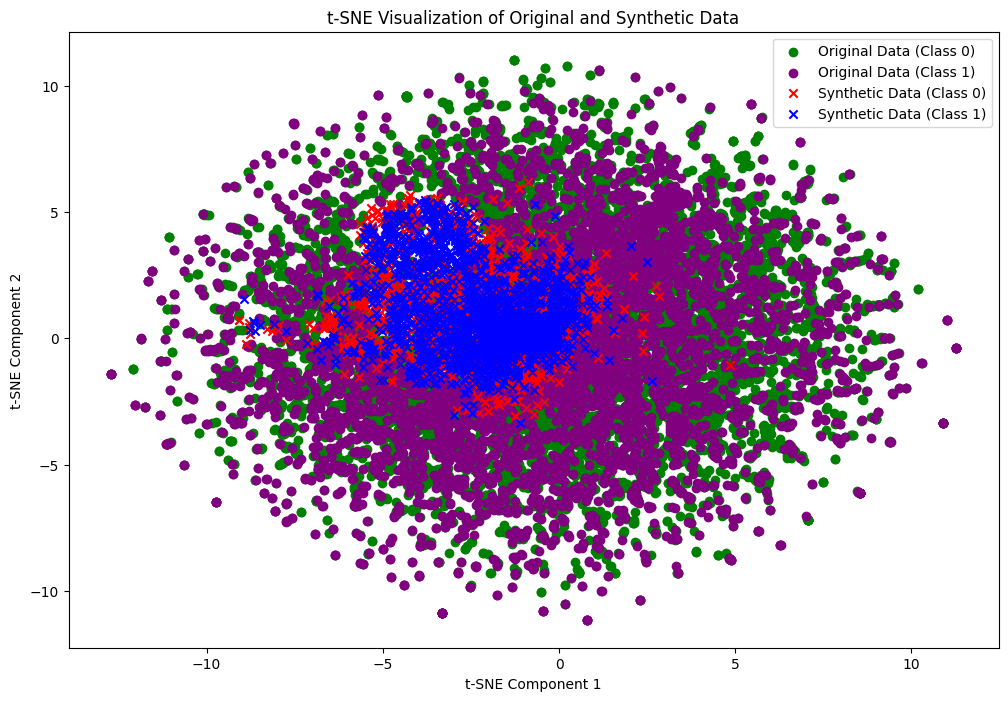


GMM Cluster Labelling MNB VAL SCORE: 0.6985802908426962


In [21]:
# GMM sampling / cluster labelling

# GMM Sampling
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

def augment_with_gmm(X, n_samples):
    # 1 component as need to label with the corresponding y values
    gmm = GaussianMixture(n_components=1)
    gmm.fit(X)
    X_synthetic, _ = gmm.sample(n_samples)
    return X_synthetic

# Generate 2000 synthetic samples for each class
n_samples = 2000
X_synthetic_0 = augment_with_gmm(X_train_0, n_samples)
X_synthetic_1 = augment_with_gmm(X_train_1, n_samples)

# Create corresponding labels for synthetic data
y_synthetic_0 = [0] * n_samples
y_synthetic_1 = [1] * n_samples

# Combine original and synthetic data
X_train_augmented = np.vstack((X_train, X_synthetic_0, X_synthetic_1))
y_train_augmented = np.hstack((y_train, y_synthetic_0, y_synthetic_1))

# Print shapes to verify augmentation
print("Samples added:", n_samples)
print("Original X_train shape:", X_train.shape)
print("Augmented X_train shape:", X_train_augmented.shape)
print("Augmented y_train shape:", y_train_augmented.shape)

mmscale = MinMaxScaler()
X_train_augmented = mmscale.fit_transform(X_train_augmented)
X_val_augmented = mmscale.transform(X_val)
X_test_augmented = mmscale.transform(X_test)

mnb.fit(X_train_augmented, y_train_augmented)
y_pred_val = mnb.predict(X_val_augmented)
print(f'\nGMM Sampling MNB VAL SCORE: {f1_score(y_val, y_pred_val, average="macro")}')

# TSNE used to show GMM-augmented samples are drawn from same probability distribution as originals
tsne = TSNE(n_components=2, random_state=1)
X_embedded = tsne.fit_transform(X_train_augmented)

X_embedded_original = X_embedded[:len(X_train)]
X_embedded_synthetic = X_embedded[len(X_train):]

# Create boolean masks for synthetic data labels
y_synthetic = np.hstack((y_synthetic_0, y_synthetic_1))
mask_synthetic_0 = y_synthetic == 0
mask_synthetic_1 = y_synthetic == 1

# Separate t-SNE embeddings for original data classes
X_embedded_original_0 = X_embedded_original[y_train == 0]
X_embedded_original_1 = X_embedded_original[y_train == 1]

# Separate t-SNE embeddings for synthetic data classes
X_embedded_synthetic_0 = X_embedded_synthetic[mask_synthetic_0]
X_embedded_synthetic_1 = X_embedded_synthetic[mask_synthetic_1]

plt.figure(figsize=(12, 8))
plt.scatter(X_embedded_original_0[:, 0], X_embedded_original_0[:, 1], c='green', marker='o', label='Original Data (Class 0)')
plt.scatter(X_embedded_original_1[:, 0], X_embedded_original_1[:, 1], c='purple', marker='o', label='Original Data (Class 1)')
plt.scatter(X_embedded_synthetic_0[:, 0], X_embedded_synthetic_0[:, 1], c='red', marker='x', label='Synthetic Data (Class 0)')
plt.scatter(X_embedded_synthetic_1[:, 0], X_embedded_synthetic_1[:, 1], c='blue', marker='x', label='Synthetic Data (Class 1)')
plt.legend()
plt.title('t-SNE Visualization of Original and Synthetic Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()







# GMM Cluster Labelling 
# 2 components used as there are only 2 classes (positive/negative sentiments)
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train)
cluster_train = gmm.predict(X_train)
cluster_val = gmm.predict(X_val)
cluster_test = gmm.predict(X_test)
X_train_labelled = np.hstack((X_train, cluster_train.reshape(-1, 1)))
X_val_labelled = np.hstack((X_val, cluster_val.reshape(-1, 1)))
X_test_labelled = np.hstack((X_test, cluster_test.reshape(-1, 1)))

mnb.fit(X_train_labelled, y_train)
y_pred_val = mnb.predict(X_val_labelled)
print(f'\nGMM Cluster Labelling MNB VAL SCORE: {f1_score(y_val, y_pred_val, average="macro")}')

Without a Gaussian distribution, the augmented data is clustered in a region.

Therefore, Gaussian transformation is necessary to be paired with, and performed before any Augmentation with GMM

Samples added: 2000
Original X_train shape: (13747, 5000)
Augmented X_train shape: (17747, 5000)
Augmented y_train shape: (17747,)

Gaussian transformed, THEN GMM Sampling MNB VAL SCORE: 0.6880171134983327


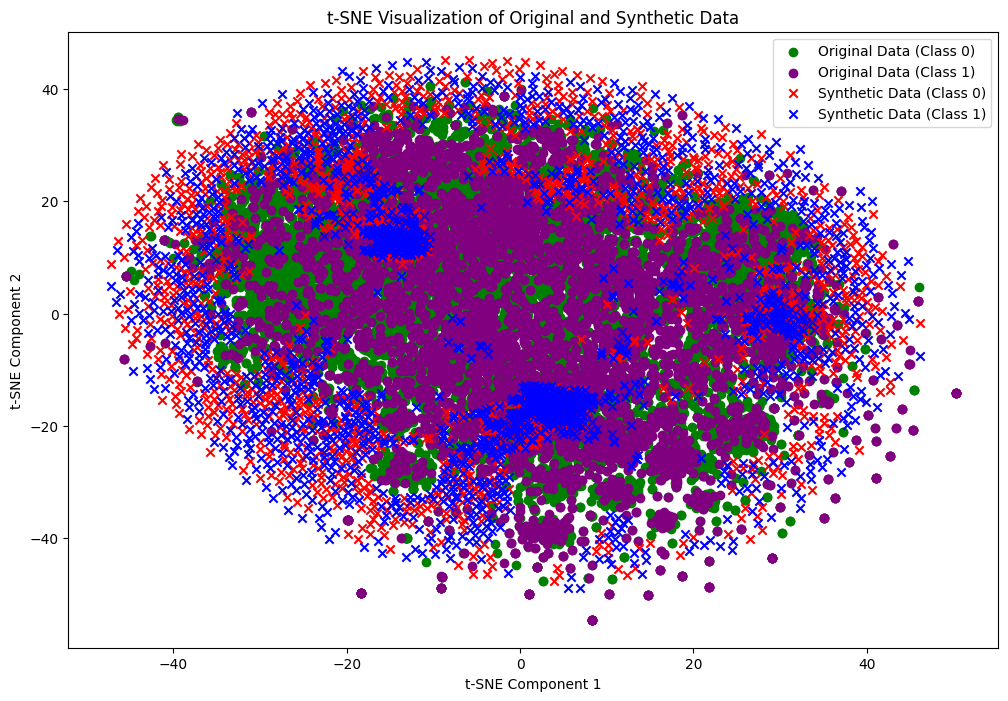

GMM Cluster Labelling MNB VAL SCORE: 0.6896646327699313


In [53]:
# Gaussian transformed, THEN GMM sampling / cluster labelling

qt = QuantileTransformer(output_distribution="normal")
X_train_qt = qt.fit_transform(X_train)
X_val_qt = qt.transform(X_val)
X_test_qt = qt.transform(X_test)

# Gaussian transformed, THEN GMM Sampling
X_train_0 = X_train_qt[y_train == 0]
X_train_1 = X_train_qt[y_train == 1]

def augment_with_gmm(X, n_samples):
    # 1 component as need to label with the corresponding y values
    gmm = GaussianMixture(n_components=1)
    gmm.fit(X)
    X_synthetic, _ = gmm.sample(n_samples)
    return X_synthetic

# Generate 2000 synthetic samples for each class
n_samples = 2000
X_synthetic_0 = augment_with_gmm(X_train_0, n_samples)
X_synthetic_1 = augment_with_gmm(X_train_1, n_samples)

# Create corresponding labels for synthetic data
y_synthetic_0 = [0] * n_samples
y_synthetic_1 = [1] * n_samples

# Combine original and synthetic data
X_train_augmented = np.vstack((X_train_qt, X_synthetic_0, X_synthetic_1))
y_train_augmented = np.hstack((y_train, y_synthetic_0, y_synthetic_1))

# Print shapes to verify augmentation
print("Samples added:", n_samples)
print("Original X_train shape:", X_train.shape)
print("Augmented X_train shape:", X_train_augmented.shape)
print("Augmented y_train shape:", y_train_augmented.shape)

mmscale = MinMaxScaler()
X_train_augmented_mm = mmscale.fit_transform(X_train_augmented)
X_val_augmented_mm = mmscale.transform(X_val_qt)
X_test_augmented_mm = mmscale.transform(X_test_qt)

mnb.fit(X_train_augmented_mm, y_train_augmented)
y_pred_val = mnb.predict(X_val_augmented_mm)
print(f'\nGaussian transformed, THEN GMM Sampling MNB VAL SCORE: {f1_score(y_val, y_pred_val, average="macro")}')

# TSNE used to show GMM-augmented samples are drawn from same probability distribution as originals
tsne = TSNE(n_components=2, random_state=1)
X_embedded = tsne.fit_transform(X_train_augmented)

X_embedded_original = X_embedded[:len(X_train)]
X_embedded_synthetic = X_embedded[len(X_train):]

# Create boolean masks for synthetic data labels
y_synthetic = np.hstack((y_synthetic_0, y_synthetic_1))
mask_synthetic_0 = y_synthetic == 0
mask_synthetic_1 = y_synthetic == 1

# Separate t-SNE embeddings for original data classes
X_embedded_original_0 = X_embedded_original[y_train == 0]
X_embedded_original_1 = X_embedded_original[y_train == 1]

# Separate t-SNE embeddings for synthetic data classes
X_embedded_synthetic_0 = X_embedded_synthetic[mask_synthetic_0]
X_embedded_synthetic_1 = X_embedded_synthetic[mask_synthetic_1]

plt.figure(figsize=(12, 8))
plt.scatter(X_embedded_original_0[:, 0], X_embedded_original_0[:, 1], c='green', marker='o', label='Original Data (Class 0)')
plt.scatter(X_embedded_original_1[:, 0], X_embedded_original_1[:, 1], c='purple', marker='o', label='Original Data (Class 1)')
plt.scatter(X_embedded_synthetic_0[:, 0], X_embedded_synthetic_0[:, 1], c='red', marker='x', label='Synthetic Data (Class 0)')
plt.scatter(X_embedded_synthetic_1[:, 0], X_embedded_synthetic_1[:, 1], c='blue', marker='x', label='Synthetic Data (Class 1)')
plt.legend()
plt.title('t-SNE Visualization of Original and Synthetic Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()







# Gaussian transformed, THEN GMM Cluster Labelling 
# 2 components used as there are only 2 classes (positive/negative sentiments)
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train_qt)
cluster_train = gmm.predict(X_train_qt)
cluster_val = gmm.predict(X_val_qt)
cluster_test = gmm.predict(X_test_qt)
X_train_labelled = np.hstack((X_train_qt, cluster_train.reshape(-1, 1)))
X_val_labelled = np.hstack((X_val_qt, cluster_val.reshape(-1, 1)))
X_test_labelled = np.hstack((X_test_qt, cluster_test.reshape(-1, 1)))

mmscale = MinMaxScaler()
X_train_labelled_mm = mmscale.fit_transform(X_train_labelled)
X_val_labelled_mm = mmscale.transform(X_val_labelled)
X_test_labelled_mm = mmscale.transform(X_test_labelled)

mnb.fit(X_train_labelled_mm, y_train)
y_pred_val = mnb.predict(X_val_labelled_mm)
print(f'\nGMM Cluster Labelling MNB VAL SCORE: {f1_score(y_val, y_pred_val, average="macro")}')

As evident, via the QuantileTransformer, the data achieved a Gaussian distribution, and therefore the augmented data more closely resembles the original dataset. The Macro F1-score also improves as a result. However, the computation time also increased quite a bit.

In [27]:
# Sampling 
%pip install imblearn
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN()
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train, y_train)
mnb.fit(X_train_smoteenn, y_train_smoteenn)
y_pred_val = mnb.predict(X_val)
print(f'\nSMOTEENN Sampling MNB VAL SCORE: {f1_score(y_val, y_pred_val, average="macro")}')


SMOTEENN Sampling MNB VAL SCORE: 0.4335056821183522


As evident, the processing above did not significantly improve the scores of the Multinomial Naive Bayes (MNB) model alone. However, when considering various other models, there can be a considerable overall impact. Thus, the following code allows for random iteration through the different combinations

Most notably, sampling is not suitable for the macro F1 score and thus removed, as it performed the worst out of the possible processing techniques

In [27]:
import itertools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import random

changes = {
    'corr': ['yes', 'no'],
    'corr_num': range(0.1, 1, 0.1),
    'dim_red': ['pca', 'svd', 'no'],
    'transform': ['power', 'quantile', 'no'],
    'gmm': ['yes', 'no'],
}

for i in range(1, 11):
    print(f"Iteration {i}")

    random_changes = {key: random.choice(value) for key, value in changes.items()}
    # If no normal-transform => no gmm
    while (random_changes["transform"] == "no" and random_changes["gmm"] == "yes"):
        random_changes = {key: random.choice(value) for key, value in changes.items()}
    print(f"random_changes: {random_changes}")

    df_train = pd.read_csv(f"{FOLDER}/data/train_tfidf_features.csv")
    X = df_train.drop(['label', 'id'], axis=1)
    y = df_train['label']
    df_test = pd.read_csv(f"{FOLDER}/data/test_tfidf_features.csv")
    X_test = df_test.drop(['id'], axis=1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1059, stratify=y)

    if random_changes["corr"] == 'yes':
        corr_matrix = X_train.corr().abs()
        threshold = random_changes["corr_num"]
        high_corr_var = np.where(corr_matrix > threshold)
        high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
        to_drop = set()
        for var1, var2 in high_corr_var:
            to_drop.add(var2) 
        X_train = X_train.drop(columns=to_drop)
        X_val = X_val.drop(columns=to_drop)
        X_test = X_test.drop(columns=to_drop)

    if random_changes["gmm"] == 'yes':
        if random_changes["transform"] == 'power':
            if random_changes["dim_red"] == 'pca':
                pca = PCA(n_components=4000)
                X_train = pca.fit_transform(X_train)
                X_val = pca.transform(X_val)
                X_test = pca.transform(X_test)

            elif random_changes["dim_red"] == 'svd':
                svd = TruncatedSVD(n_components=4000)
                X_train = svd.fit_transform(X_train)
                X_val = svd.transform(X_val)
                X_test = svd.transform(X_test)

            pt = PowerTransformer(method='yeo-johnson')
            X_train = pt.fit_transform(X_train)
            X_val = pt.transform(X_val)
            X_test = pt.transform(X_test)
            
        elif random_changes["transform"] == 'quantile':
            if random_changes["dim_red"] == 'pca':
                pca = PCA(n_components=4000)
                X_train = pca.fit_transform(X_train)
                X_val = pca.transform(X_val)
                X_test = pca.transform(X_test)

            elif random_changes["dim_red"] == 'svd':
                svd = TruncatedSVD(n_components=4000)
                X_train = svd. fit_transform(X_train)
                X_val = svd.transform(X_val)
                X_test = svd.transform(X_test)

            qt = QuantileTransformer(output_distribution="normal")
            X_train = qt.fit_transform(X_train)
            X_val = qt.transform(X_val)
            X_test = qt.transform(X_test)
            
        X_train_0 = X_train[y_train == 0]
        X_train_1 = X_train[y_train == 1]
        def augment_with_gmm(X, n_samples):
            gmm = GaussianMixture(n_components=1)
            gmm.fit(X)
            X_synthetic, _ = gmm.sample(n_samples)
            return X_synthetic
        n_samples = 2000
        X_synthetic_0 = augment_with_gmm(X_train_0, n_samples)
        X_synthetic_1 = augment_with_gmm(X_train_1, n_samples)
        y_synthetic_0 = [0] * n_samples
        y_synthetic_1 = [1] * n_samples
        X_train = np.vstack((X_train, X_synthetic_0, X_synthetic_1))
        y_train = np.hstack((y_train, y_synthetic_0, y_synthetic_1))

        gmm = GaussianMixture(n_components=2)
        gmm.fit(X_train)
        cluster_train = gmm.predict(X_train)
        cluster_val = gmm.predict(X_val)
        cluster_test = gmm.predict(X_test)
        X_train = np.hstack((X_train, cluster_train.reshape(-1, 1)))
        X_val = np.hstack((X_val, cluster_val.reshape(-1, 1)))
        X_test = np.hstack((X_test, cluster_test.reshape(-1, 1)))

    else:
        if random_changes["transform"] == 'power':
            if random_changes["dim_red"] == 'pca':
                pca = PCA(n_components=4000)
                X_train = pca.fit_transform(X_train)
                X_val = pca.transform(X_val)
                X_test = pca.transform(X_test)

            elif random_changes["dim_red"] == 'svd':
                svd = TruncatedSVD(n_components=4000)
                X_train = svd.fit_transform(X_train)
                X_val = svd.transform(X_val)
                X_test = svd.transform(X_test)

            pt = PowerTransformer(method='yeo-johnson')
            X_train = pt.fit_transform(X_train)
            X_val = pt.transform(X_val)
            X_test = pt.transform(X_test)
            
        elif random_changes["transform"] == 'quantile':
            if random_changes["dim_red"] == 'pca':
                pca = PCA(n_components=4000)
                X_train = pca.fit_transform(X_train)
                X_val = pca.transform(X_val)
                X_test = pca.transform(X_test)

            elif random_changes["dim_red"] == 'svd':
                svd = TruncatedSVD(n_components=4000)
                X_train = svd. fit_transform(X_train)
                X_val = svd.transform(X_val)
                X_test = svd.transform(X_test)

            qt = QuantileTransformer(output_distribution="normal")
            X_train = qt.fit_transform(X_train)
            X_val = qt.transform(X_val)
            X_test = qt.transform(X_test)

    mmscale = MinMaxScaler()
    X_train = mmscale.fit_transform(X_train)
    X_val = mmscale.transform(X_val)
    X_test = mmscale.transform(X_test)

    models = [
        ('cnb', ComplementNB()),
        ('lr', LogisticRegression()),
        ('xgb', XGBClassifier()),
        ('gb', GradientBoostingClassifier()),
    ]

    param_grids = {
        'cnb': { 'alpha': np.linspace(0, 5, 100000), "force_alpha": [True, False], "fit_prior": [True, False], "norm":[True, False] },
        'lr': {'C': np.linspace(1e-4, 1e4, 1000), 'fit_intercept': [True, False], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  'max_iter': range(20000, 40000, 5000), 'class_weight': [None, 'balanced']},
        'xgb':  { "n_estimators": range(1000, 3000, 100), "max_depth": range(5, 15, 1), "learning_rate": np.linspace(0.01, 1, num=100), "subsample": np.linspace(0.6, 0.9, 100),  "colsample_bytree": np.linspace(0.1, 1, 100)},
        'gb': { 'n_estimators': range(100, 300, 5), 'learning_rate': np.linspace(0.1, 0.5, 100), 'max_depth': range(3, 13, 1)},
    }

    best_models = []
    for (name, model) in models:
        print(name)
        if param_grids.get(name):
            # Memory-intensive, computationally-long models have lower iterations 
            if name in ["xgb", "gb"]:
                search = RandomizedSearchCV(model, param_grids[name], n_iter=3, cv=5, n_jobs=-1)
                search.fit(X_train, y_train)
                print(search.best_params_)
                print(search.best_score_)
                best_model = search.best_estimator_
            else: 
                search = RandomizedSearchCV(model, param_grids[name], n_iter=10, cv=5, n_jobs=-1)
                search.fit(X_train, y_train)
                print(search.best_params_)
                print(search.best_score_)
                best_model = search.best_estimator_
        else:
            best_model = model

        best_model.fit(X_train, y_train)
        best_models.append((name, best_model))

        y_pred_val = best_model.predict(X_val)
        print(f'MODEL VAL SCORES: {f1_score(y_val, y_pred_val, average="macro")}')


Iteration 1
random_changes: {'corr': 'yes', 'corr_num': 0.1, 'dim_red': 'pca', 'transform': 'no', 'gmm': 'no'}
cnb
{'norm': True, 'force_alpha': True, 'fit_prior': True, 'alpha': 3.9842898428984292}
0.6487230860949058
MODEL VAL SCORES: 0.6279486338241265
lr
{'solver': 'saga', 'max_iter': 30000, 'fit_intercept': False, 'class_weight': None, 'C': 5495.495540540542}
0.6496690909230991
MODEL VAL SCORES: 0.624246691996823
xgb
{'subsample': 0.6454545454545454, 'n_estimators': 2300, 'max_depth': 10, 'learning_rate': 0.060000000000000005, 'colsample_bytree': 0.2181818181818182}
0.6402851882618187
MODEL VAL SCORES: 0.6073080922086324
gb
{'n_estimators': 265, 'max_depth': 7, 'learning_rate': 0.19292929292929295}
0.6623986490676834
MODEL VAL SCORES: 0.6072976253505792
Iteration 2
random_changes: {'corr': 'yes', 'corr_num': 0.6, 'dim_red': 'pca', 'transform': 'quantile', 'gmm': 'no'}
cnb
{'alpha': 3.4967349673496737, 'force_alpha': False, 'fit_prior': True, 'norm': True}
0.6736103027376522
MODEL 

Therefore, the best combination for data processing was Iteration 8:

{'corr': 'yes', 'corr_num': 0.4, 'dim_red': 'no', 'transform': 'quantile', 'gmm': 'no'}

- ('cnb', ComplementNB(**{'norm': False, 'force_alpha': False, 'fit_prior': True, 'alpha': 4.74659746597466})), 
- ('lr', LogisticRegression(C=0.3593813663804626,class_weight='balanced', fit_intercept=True, max_iter=25000,solver='newton-cg')), 
- ('xgb', XGBClassifier(**{'subsample': 0.7393939393939395,'n_estimators': 2200, 'max_depth': 8, 'learning_rate': 0.1,'colsample_bytree': 0.5909090909090909})), 
- ('gb', GradientBoostingClassifier(**{'n_estimators': 265, 'max_depth':5, 'learning_rate': 0.11783783783783784}))

with the following key hyperparameters for each model
- ComplementNB
    - norm: False
        - Whether to normalize the weights of each class by the number of samples in each class.
        - The dataset is already Gaussian-transformed by QuantileTransformer and thus the TF-IDF features are already normalized, so additional normalization is not necessary and could even degrade performance.
    - force_alpha: False
        - Forces the use of the alpha parameter even when it is not strictly necessary for the computation
        - This avoids unnecessary regularization if it is not required. Particularly beneficial for TF-IDF features, which often have a natural sparsity and structure that does not always need smoothing.
    - fit_prior: True
        - Whether to learn class prior probabilities or not
        - Helps the model understand the imbalance in class distribution, where class 0 dominates class 1 by a ratio of 1.62
    - alpha: 4.74659746597466
        - Additive (Laplace/Lidstone) smoothing parameter. It helps to avoid zero probabilities in the calculation by adding a small number to the counts. A higher alpha indicates more smoothing.
        - For TF-IDF features, some words might appear very infrequently, and smoothing helps to prevent zero probabilities, thus making the model more robust to rare words.
- LogisticRegression
    - C: 0.3593813663804626
        - Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.
        - Helps prevent overfitting, which is important given the high dimensionality of 5000 TF-IDF features. Regularization constrains the magnitude of the coefficients, preventing any one feature from dominating the model.
    - class_weight: 'balanced'
        - Weights associated with classes
        - Balanced uses the values of y to automatically adjust weights inversely proportional to class frequencies. Particularly useful for sentiment analysis, where class imbalance is common and can lead to biased predictions 
    - fit_intercept: True
        - Specifies if a constant (bias or intercept) should be added to the decision function.
        - Allows the model to adjust for the global mean of the target variable, which can help improve prediction accuracy by shifting the decision boundary.
    - max_iter: 25000
        - Maximum number of iterations taken for the solvers to converge
        - Ensures that the optimization process has enough time to converge, especially important for our complex and high-dimensional TF-IDF data.
    - solver: 'newton-cg'
        - Algorithm to use in the optimization problem
        - Particularly effective for handling the large number of features in TF-IDF data, and it supports L2 regularization, which helps in controlling the complexity of the model.
- XGBClassifier
    - subsample: 0.7393939393939395
        - The fraction of samples to be used for fitting the individual base learners.
        - Means using approximately 73.9% of the data for training each base learner, which helps prevent overfitting.
    - n_estimators: 2200
        - Number of gradient boosted trees. The more trees, the better the performance, but it also increases the computation time.
        - Allows the model to capture complex patterns from the high-dimensional nature of TF-IDF features, achieving better performance by iteratively refining the model.
    - max_depth: 8
        - Maximum depth of a tree. Increasing this value makes the model more complex and helps the model capture intricate patterns and interactions between features but also more likely to overfit
    - learning_rate: 0.1
        - Step size shrinkage used in updates to prevent overfitting
        - Ensures that each boosting step makes a meaningful contribution without overwhelming the model with large updates.
    - colsample_bytree: 0.5909090909090909
        - Subsample ratio of columns when constructing each tree
        - Uses about 59% of the columns, making each tree less correlated with others, making the model robust and less prone to overfitting.
- GradientBoostingClassifier
    - n_estimators: 265
        - The number of boosting stages to be run. More stages lead to better performance but also more computation.
    - max_depth: 5
        - Maximum depth of the individual regression estimators. Deeper trees are more complex and can lead to overfitting.
    - learning_rate: 0.11783783783783784
        - Learning rate shrinks the contribution of each tree by learning_rate
        - Makes the model more robust by reducing overfitting

In [52]:
df_train = pd.read_csv(f"{FOLDER}/data/train_tfidf_features.csv")
X = df_train.drop(['label', 'id'], axis=1)
y = df_train['label']
df_test = pd.read_csv(f"{FOLDER}/data/test_tfidf_features.csv")
X_test = df_test.drop(['id'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1059, stratify=y)

corr_matrix = X_train.corr().abs()
threshold = 0.4
high_corr_var = np.where(corr_matrix > threshold)
high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
to_drop = set()
for var1, var2 in high_corr_var:
    to_drop.add(var2) 
X_train = X_train.drop(columns=to_drop)
X_val = X_val.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

qt = QuantileTransformer(output_distribution="normal")
X_train = qt.fit_transform(X_train)
X_val = qt.transform(X_val)
X_test = qt.transform(X_test)

mmscale = MinMaxScaler()
X_train = mmscale.fit_transform(X_train)
X_val = mmscale.transform(X_val)
X_test = mmscale.transform(X_test)

param_grids = {
    'voting_ensemble': {
            "voting": ["soft"], 
            # Get auto-generated list of 4 numbers, where each number can be 1 / 2 / 3, but dont allow all same numbers
            "weights": [ combo for combo in list(itertools.product([1, 2, 3], repeat=4)) if len(set(combo)) != 1],
            "flatten_transform": [False, True], 
        },
    }

voting_ensemble = VotingClassifier(estimators=[
    ('cnb', ComplementNB(**{'norm': False, 'force_alpha': False, 'fit_prior': True, 'alpha': 4.74659746597466})), 
    ('lr', LogisticRegression(C=0.3593813663804626, class_weight='balanced', fit_intercept=True, max_iter=25000, solver='newton-cg')), 
    ('xgb', XGBClassifier(**{'subsample': 0.7393939393939395, 'n_estimators': 2200, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.5909090909090909})), 
    ('gb', GradientBoostingClassifier(**{'n_estimators': 265, 'max_depth': 5, 'learning_rate': 0.11783783783783784})),
])
search = RandomizedSearchCV(voting_ensemble, param_grids["voting_ensemble"], n_iter=5, cv=7, verbose=2, n_jobs=-1)
search.fit(X_train, y_train)
print(search.best_params_)
print(search.best_score_)
best_model = search.best_estimator_
best_model.fit(X_train, y_train)

y_pred_val = best_model.predict(X_val)
print(f'ENSEMBLE VAL SCORES: {f1_score(y_val, y_pred_val, average="macro")}')

y_pred_test = best_model.predict(X_test)
pred_df = pd.DataFrame({ "id": np.arange(17185, 21481), "label": y_pred_test })
pred_df["label"] = pred_df['label'].astype(int)
# Final
pred_df.to_csv(f"predictions_{'-'.join([f'{k}_{v}' for k, v in search.best_params_.items()])}-corr_0.4_cnb_lr_xgb_gb.csv", index=False)


Fitting 7 folds for each of 5 candidates, totalling 35 fits
[CV] END flatten_transform=True, voting=soft, weights=(3, 2, 3, 3); total time=57.4min
[CV] END flatten_transform=True, voting=soft, weights=(1, 2, 1, 2); total time=50.5min
[CV] END flatten_transform=True, voting=soft, weights=(1, 2, 1, 2); total time=51.7min
[CV] END flatten_transform=True, voting=soft, weights=(1, 2, 1, 3); total time=52.2min
[CV] END flatten_transform=True, voting=soft, weights=(1, 2, 1, 3); total time=52.3min
[CV] END flatten_transform=True, voting=soft, weights=(3, 3, 2, 2); total time=50.8min
[CV] END flatten_transform=True, voting=soft, weights=(3, 3, 2, 2); total time=51.7min
[CV] END flatten_transform=False, voting=soft, weights=(2, 2, 3, 1); total time=51.9min
[CV] END flatten_transform=True, voting=soft, weights=(3, 2, 3, 3); total time=50.4min
[CV] END flatten_transform=True, voting=soft, weights=(3, 2, 3, 3); total time=50.7min
[CV] END flatten_transform=True, voting=soft, weights=(1, 2, 1, 2); 

The optimal hyperparameters for the Voting Ensemble was {'weights': (3, 3, 2, 2), 'voting': 'soft', 'flatten_transform': True}

VotingClassifier
- Weights: (3, 3, 2, 2)
    - Different weights assigned to the models respecitvely in the ensemble. The weights are used to determine the contribution of each model's predictions to the final aggregated prediction. It helps in leveraging the strengths of individual models and compensating for the weaknesses of others. Higher weights mean that the model's predictions have a greater influence on the final outcome.
    - This means the ComplementNB and Logistic Regression were both considered to be more 'influential' as compared to the XGB and GB boosting models. Thus, they are considered more reliable. 

- Voting: 'soft'
    - Specifies the type of voting strategy used. The class probabilities from each model are weighted according to the values above and the class with the highest average probability is chosen as the final prediction to make the final prediction.
    - Generally more effective than hard voting (which simply takes a majority vote) as these models are well-calibrated and have optimized hyperparameters on their own before the ensemble, producing reliable probability estimates.

- Flatten Transform: True
    - Controls whether to flatten the transform results before making predictions. True ensures that the predictions from each individual model are combined into a single 1D array before being processed further
    - Ensuring that the results from different models are properly flattened and combined helps in making sure that the final aggregation (Eg. averaging probabilities for soft voting) is done correctly

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import f1_score
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler

df_train = pd.read_csv(f"{FOLDER}/data/train_tfidf_features.csv")
X = df_train.drop(['label', 'id'], axis=1)
y = df_train['label']
df_test = pd.read_csv(f"{FOLDER}/data/test_tfidf_features.csv")
X_test = df_test.drop(['id'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1059, stratify=y)

corr_matrix = X_train.corr().abs()
threshold = 0.4
high_corr_var = np.where(corr_matrix > threshold)
high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
to_drop = set()
for var1, var2 in high_corr_var:
    to_drop.add(var2) 
X_train = X_train.drop(columns=to_drop)
X_val = X_val.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

qt = QuantileTransformer(output_distribution="normal")
X_train = qt.fit_transform(X_train)
X_val = qt.transform(X_val)
X_test = qt.transform(X_test)
mmscale = MinMaxScaler()
X_train = mmscale.fit_transform(X_train)
X_val = mmscale.transform(X_val)
X_test = mmscale.transform(X_test)

# Define first layer models
first_layer_models = [
    ('lr', LogisticRegression(C=0.3593813663804626, class_weight='balanced', fit_intercept=True, max_iter=25000, solver='newton-cg')),
    ('svc', SVC(**{'probability': True, 'kernel': 'sigmoid', 'gamma': 0.001, 'degree': 5, 'C': 132})),
    ('cnb', ComplementNB(**{'norm': True, 'force_alpha': False, 'fit_prior': False, 'alpha': 4.627681276812768})),
    ('ridge', RidgeClassifier(**{'alpha': 1.5547235472354723}))
]

# Define second layer models
second_layer_models = [
    ('gb', GradientBoostingClassifier(**{'n_estimators': 265, 'max_depth': 5, 'learning_rate': 0.11783783783783784})),
    ('xgb', XGBClassifier(**{'subsample': 0.7393939393939395, 'n_estimators': 2200, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.5909090909090909}))
]

# Hyperparameter grids for RandomizedSearchCV
param_grids = {
    'meta_lr': { 'C': np.logspace(-4, 4, 10), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter':  range(20000, 40000, 5000), 'fit_intercept':  [True, False], 'class_weight':  [None, 'balanced'], },
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1059)

# Train first layer models and get meta-features
base_meta_features = np.zeros((X_train.shape[0], len(first_layer_models)))

for i, (name, model) in enumerate(first_layer_models):
    print(name)
    preds = np.zeros(X_train.shape[0])
    for train_index, valid_index in kf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        best_model = model.fit(X_train_fold, y_train_fold)
        
        preds[valid_index] = best_model.predict(X_valid_fold)
        print(f'MODEL VAL SCORES: {f1_score(y_valid_fold, preds[valid_index], average="macro")}')
    
    base_meta_features[:, i] = preds

# Train second layer models and get meta-features
next_layer_meta_features = np.zeros((X_train.shape[0], len(second_layer_models)))

for i, (name, model) in enumerate(second_layer_models):
    print(name)
    preds = np.zeros(X_train.shape[0])
    combined_meta_features = np.hstack((X_train, base_meta_features))
    for train_index, valid_index in kf.split(combined_meta_features, y_train):
        X_train_fold, X_valid_fold = combined_meta_features[train_index], combined_meta_features[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        best_model = model.fit(X_train_fold, y_train_fold)
        
        preds[valid_index] = best_model.predict(X_valid_fold)
        print(f'MODEL VAL SCORES: {f1_score(y_valid_fold, preds[valid_index], average="macro")}')
    
    next_layer_meta_features[:, i] = preds

# Define and train meta-model
meta_model = LogisticRegression()
meta_search = RandomizedSearchCV(meta_model, param_grids["meta_lr"], n_iter=10, cv=12, random_state=1059, n_jobs=-1)
meta_search.fit(np.hstack((combined_meta_features, next_layer_meta_features)), y_train)
best_meta_model = meta_search.best_estimator_
print(meta_search.best_params_)
print(f'CASCADING TRAINING SCORES: {meta_search.best_score_}')

# Validation predictions
base_meta_features_val = np.column_stack([model.predict(X_val) for _, model in first_layer_models])
next_layer_meta_features_val = np.column_stack([model.predict(np.hstack((X_val, base_meta_features_val))) for _, model in second_layer_models])
y_pred_val = best_meta_model.predict(np.hstack((X_val, base_meta_features_val, next_layer_meta_features_val)))

print(f'CASCADING VAL SCORES:: {f1_score(y_val, y_pred_val, average="macro")}')

# Test predictions
base_meta_features_test = np.column_stack([model.predict(X_test) for _, model in first_layer_models])
next_layer_meta_features_test = np.column_stack([model.predict(np.hstack((X_test, base_meta_features_test))) for _, model in second_layer_models])
y_pred_test = best_meta_model.predict(np.hstack((X_test, base_meta_features_test, next_layer_meta_features_test)))

pred_df = pd.DataFrame({"id": np.arange(17185, 21481), "label": y_pred_test})
pred_df["label"] = pred_df['label'].astype(int)
pred_df.to_csv("predictions_cascading.csv", index=False)


lr
MODEL VAL SCORES: 0.7082521882646029
MODEL VAL SCORES: 0.7061408536818372
MODEL VAL SCORES: 0.7106948401294606
MODEL VAL SCORES: 0.6996148935524896
MODEL VAL SCORES: 0.7177072441655252
svc
MODEL VAL SCORES: 0.6826179030981622
MODEL VAL SCORES: 0.6792112206637966
MODEL VAL SCORES: 0.7036231063526328
MODEL VAL SCORES: 0.677162952955614
MODEL VAL SCORES: 0.6867009306091678
cnb
MODEL VAL SCORES: 0.7052072993859619
MODEL VAL SCORES: 0.6915124082833823
MODEL VAL SCORES: 0.711932705864421
MODEL VAL SCORES: 0.6907687663819706
MODEL VAL SCORES: 0.6958654155429193
ridge
MODEL VAL SCORES: 0.6766945359528288
MODEL VAL SCORES: 0.6893233160708312
MODEL VAL SCORES: 0.6822117402595006
MODEL VAL SCORES: 0.6870803409472392
MODEL VAL SCORES: 0.6958787497670952
gb
MODEL VAL SCORES: 0.6945231701115995
MODEL VAL SCORES: 0.7023393854748603
MODEL VAL SCORES: 0.7052603945615277
MODEL VAL SCORES: 0.6862739708324022
MODEL VAL SCORES: 0.7041082008834915
xgb
MODEL VAL SCORES: 0.6765622073929942
MODEL VAL SCORE

We also tried a cascading model, but it did not give us very good results and therefore was not used

In summary, we tried at least 10 different models
- KNeighbors
- SVC
- Catboost
- RandomForest
- Multinomial Naive Bayes
- Ridge
- Cascading

and the last 5 which we used for our final model were dutifully documented on their hyperparameters

- Complement Naive Bayes
- Logistic Regression
- Xtreme Gradient Boosting
- Gradient Boosting
- Voting Ensemble

Some implementations we would have liked to try out but didn't manage to 
- [NBSVM hybrid](https://stackoverflow.com/a/40777190/16760208)

While the data preprocessing has been done in this case already, people suggest n-grams can have a notable impact

Exploring ways to reduce computational complexity while preserving results (Occam's Razor) would be beneficial too